In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [3]:
# build the vocabulary

chars = sorted(list(set(''.join(words))))
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i:c for c,i in ctoi.items()}
vocab_size = len(itoc)
print(itoc)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [39]:
# Shuffle the words

import random
random.seed(42)
random.shuffle(words)

In [40]:
# build the dataset

block_size = 8 # context length: how many characters do we take to predict the next one?

def buld_the_dataset(words):
  X,Y = [],[]

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = ctoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = buld_the_dataset(words[:n1])
Xdev, Ydev = buld_the_dataset(words[n1:n2])
Xte, Yte = buld_the_dataset(words[n2:])

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [41]:
for x,y in zip(Xtr[:7], Ytr[:7]):
  print(''.join(itoc[i.item()] for i in x), '---->', itoc[y.item()])

........ ----> e
.......e ----> b
......eb ----> r
.....ebr ----> i
....ebri ----> m
...ebrim ----> a
..ebrima ----> .


In [92]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self,x):
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, x):
    self.out = self.weight[x]
    return self.out

  def parameters(self):
    return [self.weight]

class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [80]:
torch.manual_seed(42)

In [90]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

76579


In [94]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
logits = model(Xb)
print(logits.shape)

torch.Size([4, 27])


In [95]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))


Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [96]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  #mini batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  #forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits,Yb)

  # backward pass
  for layer in model.layers:
    layer.out.retain_grad() # AFTER DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.2713
  10000/ 200000: 1.9428
  20000/ 200000: 1.9242
  30000/ 200000: 2.0122
  40000/ 200000: 1.9319
  50000/ 200000: 2.0690
  60000/ 200000: 1.6257
  70000/ 200000: 2.3789
  80000/ 200000: 1.8565
  90000/ 200000: 1.6939
 100000/ 200000: 2.4062
 110000/ 200000: 1.8335
 120000/ 200000: 1.8743
 130000/ 200000: 2.1809
 140000/ 200000: 2.0498
 150000/ 200000: 1.7950
 160000/ 200000: 1.7676
 170000/ 200000: 1.8473
 180000/ 200000: 1.9793
 190000/ 200000: 1.9836


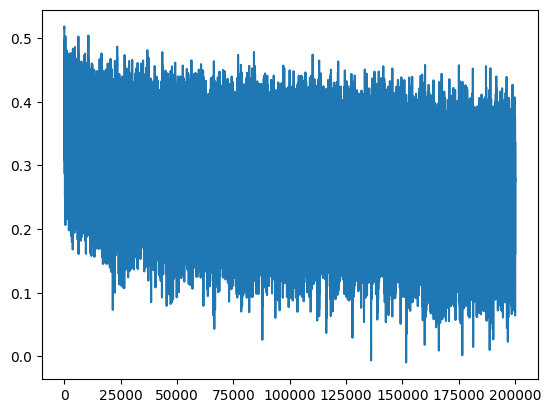

In [97]:
plt.plot(lossi)

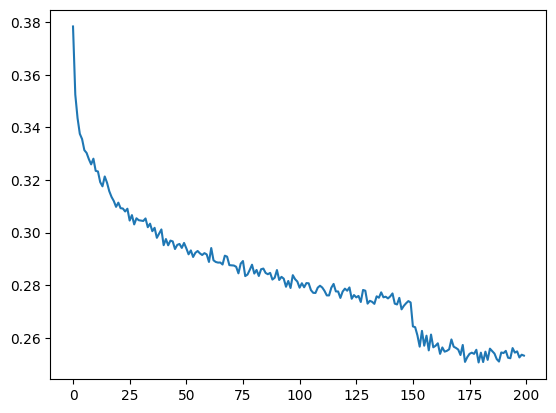

In [98]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [99]:
# put layer into eval mode
for layer in model.layers:
  layer.training = False

In [100]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7689995765686035
val 1.9874714612960815


In [101]:
# sample from the model

for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # forward pass
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the window
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itoc[i] for i in out))

zahan.
namya.
zeir.
christian.
latani.
arnuz.
bhaki.
ariany.
zay.
azriah.
navier.
kaylee.
nolaf.
jabry.
avrak.
jocelynn.
kaila.
muhaana.
blakia.
jaylin.
